In [1]:
import os
import torch
from os.path import join

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

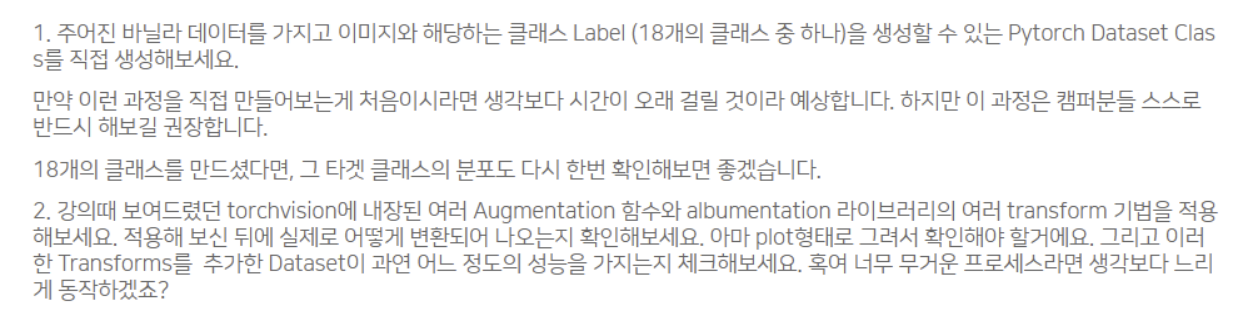

## EDA

In [2]:
train_data  = pd.read_csv(r'/opt/ml/input/data/train/train.csv')

In [3]:
train_data

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [4]:
img_folder = train_data['path']
gender = train_data['gender']
age = train_data['age']

In [5]:
img_folder

0       000001_female_Asian_45
1       000002_female_Asian_52
2         000004_male_Asian_54
3       000005_female_Asian_58
4       000006_female_Asian_59
                 ...          
2695      006954_male_Asian_19
2696      006955_male_Asian_19
2697      006956_male_Asian_19
2698      006957_male_Asian_20
2699      006959_male_Asian_19
Name: path, Length: 2700, dtype: object

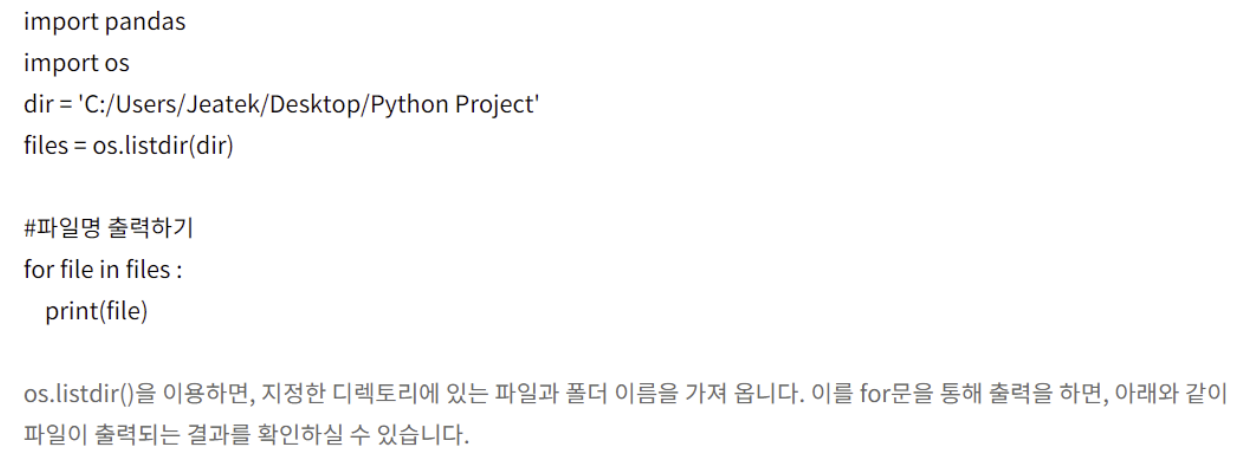

In [6]:
img_folder

0       000001_female_Asian_45
1       000002_female_Asian_52
2         000004_male_Asian_54
3       000005_female_Asian_58
4       000006_female_Asian_59
                 ...          
2695      006954_male_Asian_19
2696      006955_male_Asian_19
2697      006956_male_Asian_19
2698      006957_male_Asian_20
2699      006959_male_Asian_19
Name: path, Length: 2700, dtype: object

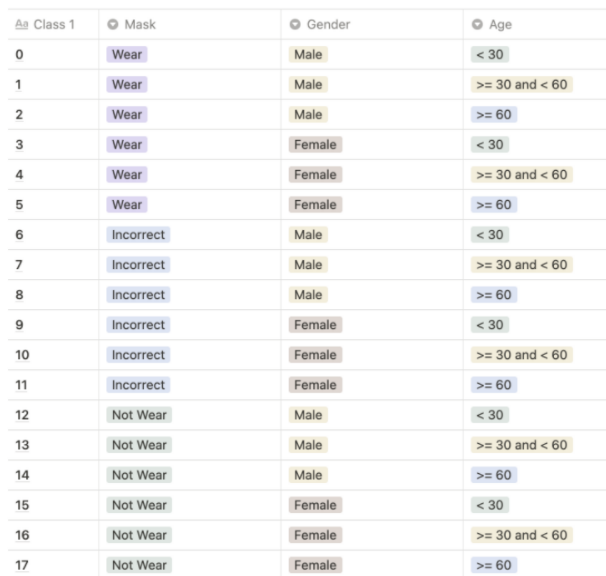

In [7]:
file_mem = []
classes = []
path = r'/opt/ml/input/data/train/images'
for i, folder in enumerate(img_folder):
    gender = train_data.iloc[i,1]
    age =   train_data.iloc[i,3]
    gen_num = 0
    #print(folder)
    if gender == "female":
        gen_num += 3
    files = os.listdir(path + '/'+ folder)
    files = [l for l in files if l[0] != '.'] 
    #print(files)
    for i, f in enumerate(files):
        class_temp = 0
        if i == 0: #incorrect mask
            class_temp += (6 + gen_num)
            if age >= 30 and age < 60:
                class_temp += 1
            elif age >= 60:
                class_temp += 2
        elif i == 6: # not wear
            class_temp += (12 + gen_num)
            if age >= 30 and age < 60:
                class_temp += 1
            elif age >= 60:
                class_temp += 2
        else: # wear
            class_temp += gen_num
            if age >= 30 and age < 60:
                class_temp += 1
            elif age >= 60:
                class_temp += 2
        #print(f, class_temp)
        file_name = folder + "/" + f
        file_mem.append(file_name)
        classes.append(class_temp)

In [8]:
file_mem = pd.DataFrame(file_mem)

In [9]:
classes = pd.DataFrame(classes)

In [10]:
file_class = pd.concat([file_mem, classes], axis = 1)
file_class.columns = ["Folder/File", "Class"]

In [11]:
file_class

,Folder/File,Class
0,000001_female_Asian_45/normal.jpg,10
1,000001_female_Asian_45/mask1.jpg,4
2,000001_female_Asian_45/mask3.jpg,4
3,000001_female_Asian_45/mask4.jpg,4
4,000001_female_Asian_45/mask2.jpg,4
...,...,...
18895,006959_male_Asian_19/mask3.jpg,0
18896,006959_male_Asian_19/mask4.jpg,0
18897,006959_male_Asian_19/mask2.jpg,0
18898,006959_male_Asian_19/mask5.jpg,0


In [12]:
file_class.head()

,Folder/File,Class
0,000001_female_Asian_45/normal.jpg,10
1,000001_female_Asian_45/mask1.jpg,4
2,000001_female_Asian_45/mask3.jpg,4
3,000001_female_Asian_45/mask4.jpg,4
4,000001_female_Asian_45/mask2.jpg,4


In [13]:
class_group = file_class.groupby(['Class']).count()

In [14]:
class_group

,Folder/File
Class,
0,2745
1,2050
2,415
3,3660
4,4085
5,545
6,549
7,410
8,83


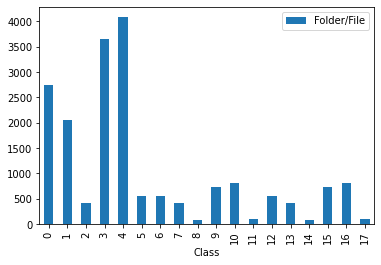

In [15]:
class_group.plot(kind = 'bar')

In [16]:
file_class.describe()

,Class
count,18900.000000
mean,5.010317
std,4.660533
min,0.000000
25%,1.000000
50%,4.000000
75%,7.000000
max,17.000000


In [17]:
file_class.shape

(18900, 2)

## DataSet 형성

In [18]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
class imgDataset(Dataset):
    def __init__(self, csv_path):
        #self.to_tensor = transforms.ToTensor()
        self.main_path = csv_path
        self.human_data = pd.read_csv(self.main_path + '/' + 'train.csv')
        self.image_folder = (self.main_path + '/' + 'images')
        self.transform = transforms.Compose([
                                            transforms.CenterCrop(384),
                                            transforms.Resize(256),
                                            transforms.ToTensor(),
                                             
                                            transforms.Normalize(mean = [0.5,0.5,0.5],
                                                                 std =[0.5,0.5,0.5])])#384 384로 crop을 하고, 그런 후 256으로 resize
        #self.path = r'C:\Users\harry\Desktop\Naver\train\train\images'
    #def __len__(self):
   #     return 7 * self.human_data.shape[0]
    def __getitem__(self,index):
        gen_num = 0
        class_num = 0
        folder_num = index // 7
        file_num = index % 7
        #human = self.human_data[folder_num]['path']
        path = self.human_data.iloc[folder_num]['path']
        gender = self.human_data.iloc[folder_num]['gender']
        age = self.human_data.iloc[folder_num]['age']
        files_temp = os.listdir(self.image_folder + '/'+ path)
        files = [l for l in files_temp if l[0] != '.'] 
        file = files[file_num]
        image = Image.open(self.image_folder+'/'+path + '/' + file)
        image = self.transform(image)
        if gender == 'female':
            gen_num += 3
        if file_num == 0:
            class_num += (6 + gen_num)
            if age >= 30 and age < 60:
                class_num += 1
            elif age >= 60:
                class_num += 2
        elif file_num == 6: # not wear
            class_num += (12 + gen_num)
            if age >= 30 and age < 60:
                class_num += 1
            elif age >= 60:
                class_num += 2
        else: # wear
            class_num += gen_num
            if age >= 30 and age < 60:
                class_num += 1
            elif age >= 60:
                class_num += 2
        return class_num, image
    def __len__(self):
        return 7 * self.human_data.shape[0]

## Dataset 확인

In [19]:
class_img = imgDataset(r'/opt/ml/input/data/train')

In [20]:
len(class_img)

18900

In [21]:
k, j = class_img[18899]

In [22]:
print(k)

12


In [23]:
print(j)

tensor([[[0.7882, 0.7882, 0.7882,  ..., 0.5686, 0.5686, 0.5686],
         [0.7882, 0.7882, 0.7882,  ..., 0.5686, 0.5686, 0.5686],
         [0.7961, 0.7961, 0.7961,  ..., 0.5765, 0.5765, 0.5765],
         ...,
         [0.6392, 0.6627, 0.6549,  ..., 0.2314, 0.2314, 0.2314],
         [0.6549, 0.6549, 0.6392,  ..., 0.2235, 0.2235, 0.2235],
         [0.6706, 0.6392, 0.6314,  ..., 0.2157, 0.2157, 0.2157]],

        [[0.7961, 0.7961, 0.7961,  ..., 0.5765, 0.5765, 0.5765],
         [0.7961, 0.7961, 0.7961,  ..., 0.5765, 0.5765, 0.5765],
         [0.8039, 0.8039, 0.8039,  ..., 0.5843, 0.5843, 0.5843],
         ...,
         [0.6549, 0.6784, 0.6627,  ..., 0.2235, 0.2235, 0.2235],
         [0.6706, 0.6706, 0.6549,  ..., 0.2157, 0.2157, 0.2157],
         [0.6941, 0.6627, 0.6392,  ..., 0.2078, 0.2078, 0.2078]],

        [[0.7490, 0.7490, 0.7490,  ..., 0.5294, 0.5294, 0.5294],
         [0.7490, 0.7490, 0.7490,  ..., 0.5294, 0.5294, 0.5294],
         [0.7569, 0.7569, 0.7569,  ..., 0.5373, 0.5373, 0.

In [24]:
i, j = class_img[18898]

In [25]:
print(i)

0


In [26]:
i, j = class_img[2]

In [27]:
print(i)

4


In [28]:
print(j)

tensor([[[ 0.4118,  0.4118,  0.4118,  ...,  0.5059,  0.5059,  0.5059],
         [ 0.4118,  0.4118,  0.4118,  ...,  0.5059,  0.5059,  0.5059],
         [ 0.4118,  0.4118,  0.4118,  ...,  0.4980,  0.4980,  0.4980],
         ...,
         [-0.5451, -0.5608, -0.5529,  ..., -0.8353, -0.8118, -0.6157],
         [-0.2863, -0.4353, -0.5451,  ..., -0.8039, -0.7647, -0.5686],
         [ 0.0353, -0.0824, -0.2784,  ..., -0.7569, -0.7176, -0.4275]],

        [[ 0.3804,  0.3804,  0.3804,  ...,  0.4980,  0.4980,  0.4980],
         [ 0.3804,  0.3804,  0.3804,  ...,  0.4980,  0.4980,  0.4980],
         [ 0.3804,  0.3804,  0.3804,  ...,  0.4902,  0.4902,  0.4902],
         ...,
         [-0.4510, -0.4667, -0.4510,  ..., -0.9216, -0.9686, -0.8745],
         [-0.1529, -0.3176, -0.4667,  ..., -0.9216, -0.9294, -0.8275],
         [ 0.2078,  0.0510, -0.2078,  ..., -0.8980, -0.8745, -0.6706]],

        [[ 0.3725,  0.3725,  0.3725,  ...,  0.4824,  0.4824,  0.4824],
         [ 0.3725,  0.3725,  0.3725,  ...,  0

In [29]:
print(type(j))

<class 'torch.Tensor'>


In [30]:
print(j.shape)

torch.Size([3, 256, 256])


## DataLoader 형성

In [31]:
from torch.utils.data import DataLoader
loaded_data = DataLoader(class_img, batch_size=64, shuffle = True)    #통상 첨에 시작할때 batch는 64에서 128로 잡는다    

## Model생성

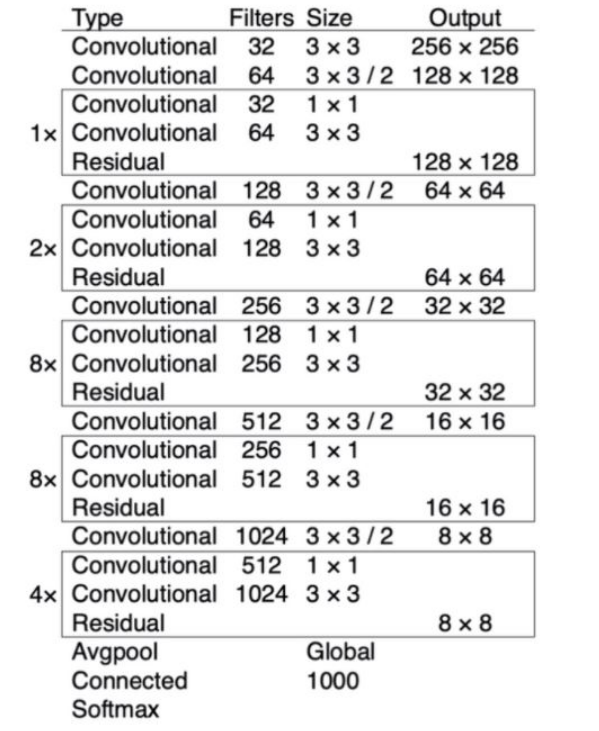

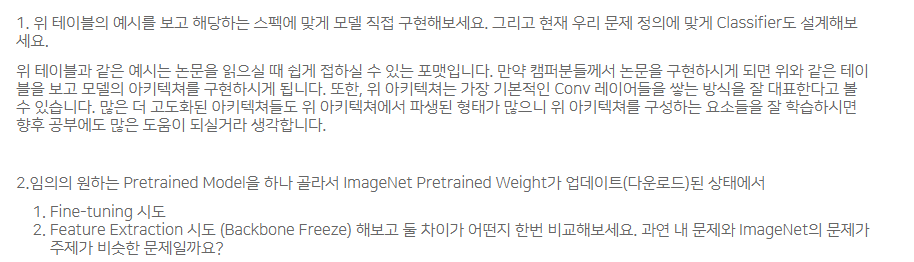

In [32]:
from pprint import pprint

import torch
import torch.nn as nn
import torch.nn.functional as F

In [33]:
class ResBlock(nn.Module): 
    def __init__(self, in_dim, mid_dim, out_dim):
        super(ResBlock,self).__init__() # Residual Block 
        self.residual_block = nn.Sequential( nn.Conv2d(in_dim, mid_dim, kernel_size=3, padding=1), 
                                            nn.ReLU(), 
                                            nn.Conv2d(mid_dim, out_dim, kernel_size=3, padding=1) ) 
        self.relu = nn.ReLU() 
    def forward(self, x): 
        out = self. residual_block(x) # F(x) 
        out = out + x # F(x) + x 
        out = self.relu(out) 
        return out

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,padding = 1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv2 =nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding = 1,stride = 2, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(64))
        self.res1 = nn.Sequential(ResBlock(64, 32, 64)
                                  #ResBlock(),
                                  #ResBlock().....
                                 )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding = 1,stride = 2, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.res2 = nn.Sequential(ResBlock(128,64,128),
                                 ResBlock(128,64,128))
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding = 1,stride = 2, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.res3 = nn.Sequential(ResBlock(256,128,256),
                                  ResBlock(256,128,256),
                                  ResBlock(256,128,256),
                                  ResBlock(256,128,256),
                                  ResBlock(256,128,256),
                                  ResBlock(256,128,256),
                                  ResBlock(256,128,256),
                                  ResBlock(256,128,256)
                                 )
        self.conv5 =nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,padding = 1,stride = 2, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.res4 = nn.Sequential(ResBlock(512,256,512),
                                  ResBlock(512,256,512),
                                  ResBlock(512,256,512),
                                  ResBlock(512,256,512),
                                  ResBlock(512,256,512),
                                  ResBlock(512,256,512),
                                  ResBlock(512,256,512),
                                  ResBlock(512,256,512)
                                 )
        self.conv6 =nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3,padding = 1,stride = 2, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(1024)
        )
        self.res5 = nn.Sequential(ResBlock(1024,512,1024),
                                  ResBlock(1024,512,1024),
                                  ResBlock(1024,512,1024),
                                  ResBlock(1024,512,1024)
                                 )
        self.avgpool = nn.AvgPool2d((1,1))#이건 왜 하는거지???
        #self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.mlp = nn.Linear(1024*8*8, 18)
    def forward(self, x):
        #x = F.relu(self.bn1(self.conv1(x)))
        #x = self.res1(x) nn.Sequential()
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.res1(output)
        output = self.conv3(output)
        output = self.res2(output)
        output = self.conv4(output)
        output = self.res3(output)
        output = self.conv5(output)
        output = self.res4(output)
        output = self.conv6(output)
        output = self.res5(output)
        output = self.avgpool(output)
        output = torch.flatten(output,1)
        output = self.mlp(output)
        return output

In [34]:
nn = Model()
for i, cl_im in enumerate(loaded_data):
    #print(cl_im[0])
    #print(cl_im[1])
    #print(type(cl_im[1]))
    output = nn(cl_im[1])
    print(output)
    exit()
    

tensor([[-0.3279, -0.4510, -0.1662,  ..., -0.3360,  0.2551,  0.2147],
        [-0.3178, -0.4609, -0.2348,  ..., -0.2857,  0.1588,  0.1188],
        [-0.2583, -0.1740, -0.1151,  ..., -0.1393,  0.1601,  0.1564],
        ...,
        [-0.5502, -0.6495, -0.3598,  ..., -0.4368,  0.0968,  0.0251],
        [-0.2864, -0.3679, -0.1977,  ..., -0.2542,  0.2258,  0.1447],
        [-0.5194, -0.6023, -0.3778,  ..., -0.6004,  0.4074, -0.0242]],
       grad_fn=<AddmmBackward>)


KeyboardInterrupt: 